# Домашнее задание № 9

### Задание 1 (5 баллов).
Это задание основано на этой тетрадке - https://github.com/mannefedov/compling_nlp_hse_course/blob/master/notebooks/transfer_learning_hg/Fine_tunining_pretrained_LMs.ipynb

Дообучите 3 предобученных модели на тех же данных, что и в семинаре. Сравните качество и выберите лучшую.
Модели должны отличаться друг от друга не только параметрами ru/en/multilingual, base/large, cased/uncased. Все три выбранные модели должны работать лучше, чем бейзлайн без дообучения (т.е. если модель не работает, попробуйте другую).


#### Инсталы

In [ ]:
import locale
locale.getpreferredencoding = lambda: "UTF-8"

In [ ]:
!pip install --upgrade keras
# !pip install torch torchvision torchaudio
# !pip install scikit-learn pandas matplotlib transformers -U

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 9.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 286.8/286.8 kB 13.4 MB/s eta 0:00:00
  Attempting uninstall: keras
    Found existing installation: keras 2.15.0
    Uninstalling keras-2.15.0:
      Successfully uninstalled keras-2.15.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow 2.15.0 requires keras<2.16,>=2.15.0, but you have keras 3.1.1 which is incompatible.


#### Импорты

In [ ]:
import os
os.environ["KERAS_BACKEND"] = "torch"

import keras
print(keras.__version__)

3.1.1


In [ ]:
# стандартные библиотеки
import os, re
import numpy as np
from time import time
from sklearn.model_selection import train_test_split
import pandas as pd
from collections import Counter
from string import punctuation
import matplotlib.pyplot as plt
%matplotlib inline


import keras, torch
from transformers import AutoModel
from transformers import AutoTokenizer

from sklearn.metrics import classification_report

#### Данные

Возьмем данные lenta.ru, но не целиком. Fine-tuning больших моделей лучше всего подходит, когда данных совсем мало и стандартным алгоритмам просто не хватает информации, чтобы обучиться. Поэтому возьмем только небольшой процент всех данных.

In [ ]:
# data_frac = pd.concat([data[data.topic=='Россия'].sample(frac=0.001),
#                       data[data.topic=='Мир'].sample(frac=0.001),
#                       data[data.topic=='Экономика'].sample(frac=0.002),
#                       data[data.topic=='Спорт'].sample(frac=0.003),
#                       data[data.topic=='Наука и техника'].sample(frac=0.005),
#                       data[data.topic=='Бывший СССР'].sample(frac=0.005),
#                       data[data.topic=='Культура'].sample(frac=0.005),
#                       data[data.topic=='Интернет и СМИ'].sample(frac=0.005),
#                       data[data.topic=='Из жизни'].sample(frac=0.01),
#                       data[data.topic=='Дом'].sample(frac=0.01),
#                       data[data.topic=='Силовые структуры'].sample(frac=0.01),
#                       data[data.topic=='Ценности'].sample(frac=0.03),
#                       data[data.topic=='Бизнес'].sample(frac=0.03),
#                       data[data.topic=='69-я параллель'].sample(frac=0.05),
#                       data[data.topic=='Крым'].sample(frac=0.05),
#                       data[data.topic=='Культпросвет'].sample(frac=0.2),
#                       data[data.topic=='Легпром'].sample(frac=0.8),
#                       data[data.topic=='Библиотека']]).reset_index(drop=True)

In [ ]:
url = 'https://raw.githubusercontent.com/mannefedov/compling_nlp_hse_course/master/notebooks/transfer_learning_hg/lenta_sample.csv'
data = pd.read_csv(url)
data.dropna(subset=['topic', 'text'], inplace=True)

In [ ]:
data.topic.value_counts()

topic
Из жизни             55
Наука и техника      54
Бывший СССР          54
Культура             53
Ценности             45
Дом                  45
Бизнес               44
Интернет и СМИ       44
Силовые структуры    40
Спорт                39
Россия               32
Экономика            32
Мир                  27
69-я параллель       13
Легпром              13
Библиотека           10
Крым                  7
Name: count, dtype: int64

In [ ]:
data.shape

(607, 6)

#### LSTM бейзлайн

In [ ]:

def preprocess(text):
    tokens = text.lower().split()
    tokens = [token.strip(punctuation) for token in tokens]
    return tokens

vocab = Counter()

for text in data.title:
    vocab.update(preprocess(text))

# индексируем слова
word2id = {'PAD':0}

for word in vocab:
    word2id[word] = len(word2id)

id2word = {i:word for word, i in word2id.items()}

X = []

for text in data.title:
    tokens = preprocess(text)
    ids = [word2id[token] for token in tokens]
    X.append(ids)

MAX_LEN = max(len(x) for x in X)


# паддинг
X = keras.preprocessing.sequence.pad_sequences(X, padding='post', maxlen=MAX_LEN)


id2label = {i:label for i, label in enumerate(set(data.topic.values))}
label2id = {l:i for i, l in id2label.items()}

y = keras.utils.to_categorical([label2id[label] for label in data.topic.values])


X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.05, stratify=data.topic)

In [ ]:
# if no gpu memory left
# del model_rubert
# torch.cuda.empty_cache()

In [ ]:
inputs = keras.layers.Input(shape=(MAX_LEN,))
embeddings = keras.layers.Embedding(input_dim=len(word2id), output_dim=30)(inputs, )

lstm = keras.layers.Bidirectional(keras.layers.LSTM(128, return_sequences=False))(embeddings)
drop = keras.layers.Dropout(0.3)(lstm)
outputs = keras.layers.Dense(len(label2id), activation='softmax')(drop)

model = keras.Model(inputs=inputs, outputs=outputs)
optimizer = keras.optimizers.Adam(learning_rate=0.001)
model.compile(optimizer=optimizer,
              loss='categorical_crossentropy',
              metrics=['accuracy'])


In [ ]:
model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, 13)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ embedding (Embedding)                │ (None, 13, 30)              │          93,060 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional (Bidirectional)        │ (None, 256)                 │         162,816 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 17)                  │           4,369 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 260,245 (1016.58 KB)

 Trainable params: 260,245 (1016.58 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
model.fit(X_train, y_train,
          validation_data=(X_valid, y_valid),
          batch_size=32,
          epochs=50)

Epoch 1/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 6s 125ms/step - accuracy: 0.0995 - loss: 2.8206 - val_accuracy: 0.0968 - val_loss: 2.7270
Epoch 2/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 2s 99ms/step - accuracy: 0.0900 - loss: 2.7410 - val_accuracy: 0.0968 - val_loss: 2.6775
Epoch 3/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 2s 109ms/step - accuracy: 0.1052 - loss: 2.6907 - val_accuracy: 0.1613 - val_loss: 2.6429
Epoch 4/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 78ms/step - accuracy: 0.1538 - loss: 2.5118 - val_accuracy: 0.0323 - val_loss: 2.7919
Epoch 5/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 2s 103ms/step - accuracy: 0.2438 - loss: 2.1589 - val_accuracy: 0.0968 - val_loss: 2.7496
Epoch 6/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 2s 106ms/step - accuracy: 0.2599 - loss: 2.0048 - val_accuracy: 0.1290 - val_loss: 2.7396
Epoch 7/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 2s 108ms/step - accuracy: 0.3177 - loss: 1.8388 - val_accuracy: 0.0645 - val_loss: 2.8940
Epoch 8/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 3s 139ms/step - accuracy: 0.3313 - loss: 1.7234 - val_accuracy: 0.09

dict_keys(['accuracy', 'loss', 'val_accuracy', 'val_loss'])


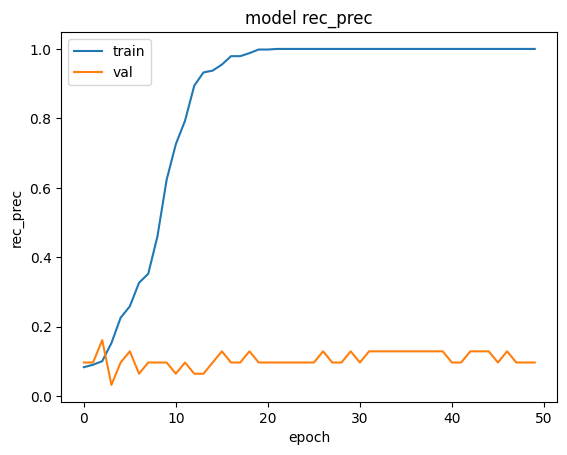

In [ ]:
print(model.history.history.keys())
plt.plot(model.history.history['accuracy'])
plt.plot(model.history.history['val_accuracy'])
plt.title('model rec_prec')
plt.ylabel('rec_prec')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [ ]:
from sklearn.metrics import classification_report

In [ ]:
pred = model.predict(X_valid, batch_size=5).argmax(1)

print(classification_report(y_valid.argmax(1), pred, labels=list(range(len(label2id))),
                            target_names=list(label2id), zero_division=0))

7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
                   precision    recall  f1-score   support

      Бывший СССР       0.00      0.00      0.00         3
           Бизнес       0.00      0.00      0.00         2
        Экономика       0.00      0.00      0.00         2
   69-я параллель       0.00      0.00      0.00         1
         Из жизни       0.00      0.00      0.00         3
          Легпром       0.00      0.00      0.00         1
              Дом       0.00      0.00      0.00         2
              Мир       0.10      1.00      0.18         1
            Спорт       0.00      0.00      0.00         2
           Россия       0.00      0.00      0.00         2
  Наука и техника       0.00      0.00      0.00         3
       Библиотека       0.00      0.00      0.00         0
         Ценности       1.00      1.00      1.00         2
   Интернет и СМИ       0.00      0.00      0.00         2
Силовые структуры       0.00      0.00      0.00         2
             Крым

#### Модель 1. DeepPavlov/rubert-base-cased

In [ ]:
from transformers import pipeline

pipe = pipeline("feature-extraction", model="DeepPavlov/rubert-base-cased")

from transformers import AutoTokenizer, AutoModel

tokenizer = AutoTokenizer.from_pretrained("DeepPavlov/rubert-base-cased")
model_rubert = AutoModel.from_pretrained("DeepPavlov/rubert-base-cased")

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/642 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/714M [00:00<?, ?B/s]

Some weights of the model checkpoint at DeepPavlov/rubert-base-cased were not used when initializing BertModel: ['cls.predictions.bias', 'cls.predictions.decoder.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


tokenizer_config.json:   0%|          | 0.00/24.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/1.65M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

Some weights of the model checkpoint at DeepPavlov/rubert-base-cased were not used when initializing BertModel: ['cls.predictions.bias', 'cls.predictions.decoder.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [ ]:
data.loc[4, 'title']

'По факту пожара на\xa0заводе в\xa0Югре заведено дело'

Перевести токены в индексы очень просто

In [ ]:
tokenizer.encode(data.loc[4, 'title'])

[101, 3099, 20615, 19842, 1469, 16543, 845, 25564, 2076, 62742, 10673, 102]

В этих моделях как правило используется BPE

In [ ]:
# переводим индекс токена обратно в текст
encoded = tokenizer.encode(data.loc[4, 'title'])
[tokenizer.decode([x]) for x in encoded]

['[CLS]',
 'По',
 'факту',
 'пожара',
 'на',
 'заводе',
 'в',
 'Юг',
 '##ре',
 'заведено',
 'дело',
 '[SEP]']

Индексы можно напрямую передавать в модель.

In [ ]:
text = data.loc[4, 'title']
text_ids = tokenizer.encode(text, add_special_tokens=True,
                            return_tensors='pt') # преобразуем в торч формат
output = model_rubert(text_ids, output_attentions=False)

На выходе мы получим tuple из двух элементов.

Первый элемент - состояния енкодера для каждого из элементов последовательности

In [ ]:
output[0].size() # в пайторче вместо .shape используется size()
output[0].shape # но shape тоже работает

torch.Size([1, 12, 768])

Второй - состояние енкодера на первом элементе, пропущенное через активацию (обычно этот элемент не используют)

In [ ]:
# в дистилберт его совсем нет, поэтому будет ошибка
# output[1].shape

Обычно в задачах используют либо состояние первого элемента

In [ ]:
output[0][:,0].shape

torch.Size([1, 768])

Либо усредненное состояние

In [ ]:
output[0].mean(axis=1).shape

torch.Size([1, 768])

Полученные эмбеддинги уже можно использовать для какой-нибудь кластеризации или поиска похожих. А если есть разметка, то можно обучить на этих векторах стандартную модель из sklearn или даже дообучить всего Берта под конкретную задачу!

Давайте попробуем дообучить (fine-tune) модель на данных lenta ru

Будем обучаться на заголовках, а не на самих текстах

In [ ]:
# переводим тексты в последовательности индексов
# У берта есть ограничение на максимальную длину последовательности - 512
# Для заголовков это не очень актуально, но для других данных пригодится

X = []

for text in data.title:
    ids = tokenizer.encode(text)

    X.append(ids[:512])

In [ ]:
X = keras.preprocessing.sequence.pad_sequences(X, padding='post', maxlen=512)

In [ ]:
id2label = {i:label for i, label in enumerate(set(data.topic.values))}
label2id = {l:i for i, l in id2label.items()}

y = keras.utils.to_categorical([label2id[label] for label in data.topic.values])


In [ ]:
X.shape

(607, 512)

В этот раз добавим стратификацию, т.к. в данных у нас дисбаланс классов.

In [ ]:
train_index, valid_index = train_test_split(list(range(len(X))), test_size=0.05, stratify=data.topic)

In [ ]:
X_train, y_train = X[train_index], y[train_index]
X_valid, y_valid = X[valid_index], y[valid_index]

Дообучение без замораживания

In [ ]:
model_rubert = AutoModel.from_pretrained('distilbert-base-multilingual-cased')

# по умолчанию веса обучаемые поэтому нужно просто загрузить модель


config.json:   0%|          | 0.00/466 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/542M [00:00<?, ?B/s]

In [ ]:
# с huggingface немного сложно, потому что он возвращает тип BaseModelOutput
# который является tuple как мы посмотрели выше
# и это немного ломает расчет размерностей в керасе потому что он пытается вытащить эту размерность
# по атрибуту .shape а BaseModelOutput нет такого
# этот атрибут есть у элементов этого tuple поэтому нужно написать вот такую простую обертку
# которая вызовет модель и вернет первый элемент tuple
class rubert_wrapper(keras.Model):
    def __init__(self, model_rubert, **kwargs):
        super().__init__(**kwargs)
        # модель нужно обернуть в специальный класс чтобы она была совместима с другими керас слоями
        self.model_rubert = keras.layers.TorchModuleWrapper(model_rubert)

    def call(self, inputs):
        x = self.model_rubert(inputs)
        return x[0]

In [ ]:
input_word_ids = keras.layers.Input(shape=(512,), dtype='int32',
                                     name="input_ids")

output = rubert_wrapper(model_rubert)(input_word_ids)
# берем только самый первый вектор (CLS токен)
drop = keras.layers.Dropout(0.1)(output[:, 0])
dense = keras.layers.Dense(y.shape[1], activation='softmax')(drop)

model_clf = keras.Model(inputs=input_word_ids, outputs=dense)


model_clf.compile(keras.optimizers.Adam(learning_rate=2e-5,
                                    ),
                  loss='categorical_crossentropy',
                  metrics=['accuracy',
                           keras.metrics.RecallAtPrecision(0.80, name='rec_prec')])




In [ ]:
if torch.cuda.is_available():
    model_clf.to('cuda')

Батч сайз нужно поставить еще меньше

In [ ]:
# если есть ошибка с device meta то попробуйте запустить еще раз
model_clf.fit(torch.LongTensor(X_train), torch.LongTensor(y_train),
          validation_data=(torch.LongTensor(X_valid), torch.LongTensor(y_valid)),
          batch_size=4,
          epochs=10)

Epoch 1/10


We strongly recommend passing in an `attention_mask` since your input_ids may be padded. See https://huggingface.co/docs/transformers/troubleshooting#incorrect-output-when-padding-tokens-arent-masked.


144/144 ━━━━━━━━━━━━━━━━━━━━ 39s 266ms/step - accuracy: 0.0825 - loss: 2.8749 - rec_prec: 0.0000e+00 - val_accuracy: 0.0645 - val_loss: 2.7027 - val_rec_prec: 0.0000e+00
Epoch 2/10
144/144 ━━━━━━━━━━━━━━━━━━━━ 37s 254ms/step - accuracy: 0.0779 - loss: 2.7730 - rec_prec: 0.0000e+00 - val_accuracy: 0.0968 - val_loss: 2.7142 - val_rec_prec: 0.0000e+00
Epoch 3/10
144/144 ━━━━━━━━━━━━━━━━━━━━ 37s 256ms/step - accuracy: 0.0659 - loss: 2.7375 - rec_prec: 3.7575e-04 - val_accuracy: 0.0645 - val_loss: 2.7083 - val_rec_prec: 0.0000e+00
Epoch 4/10
144/144 ━━━━━━━━━━━━━━━━━━━━ 37s 256ms/step - accuracy: 0.1073 - loss: 2.6327 - rec_prec: 0.0174 - val_accuracy: 0.0968 - val_loss: 2.6316 - val_rec_prec: 0.0645
Epoch 5/10
144/144 ━━━━━━━━━━━━━━━━━━━━ 37s 254ms/step - accuracy: 0.1665 - loss: 2.4965 - rec_prec: 0.0315 - val_accuracy: 0.0645 - val_loss: 2.8383 - val_rec_prec: 0.0000e+00
Epoch 6/10
144/144 ━━━━━━━━━━━━━━━━━━━━ 37s 257ms/step - accuracy: 0.1988 - loss: 2.3847 - rec_prec: 0.0276 - val_accu

dict_keys(['accuracy', 'loss', 'rec_prec', 'val_accuracy', 'val_loss', 'val_rec_prec'])


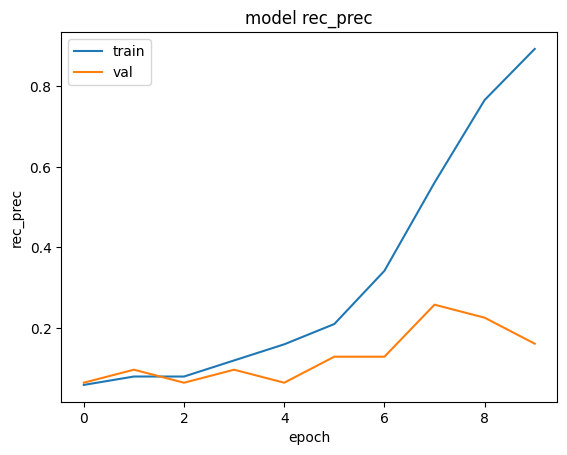

In [ ]:
print(model_clf.history.history.keys())
plt.plot(model_clf.history.history['accuracy'])
plt.plot(model_clf.history.history['val_accuracy'])
plt.title('model rec_prec')
plt.ylabel('rec_prec')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [ ]:
pred = model_clf.predict(X_valid, batch_size=5).argmax(1)

7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


In [ ]:
print(classification_report(y_valid.argmax(1), pred, labels=list(range(len(label2id))),
                            target_names=list(label2id), zero_division=0))

                   precision    recall  f1-score   support

      Бывший СССР       0.00      0.00      0.00         3
           Бизнес       0.00      0.00      0.00         2
        Экономика       0.00      0.00      0.00         2
   69-я параллель       0.00      0.00      0.00         1
         Из жизни       0.29      0.67      0.40         3
          Легпром       0.00      0.00      0.00         1
              Дом       0.00      0.00      0.00         2
              Мир       0.00      0.00      0.00         1
            Спорт       0.00      0.00      0.00         2
           Россия       0.00      0.00      0.00         2
  Наука и техника       0.20      0.67      0.31         3
       Библиотека       0.00      0.00      0.00         0
         Ценности       0.00      0.00      0.00         2
   Интернет и СМИ       0.00      0.00      0.00         2
Силовые структуры       0.00      0.00      0.00         2
             Крым       0.00      0.00      0.00       

#### Модель 2 bert-base-multilingual-uncased

In [ ]:
from transformers import pipeline

pipe = pipeline("feature-extraction", model="bert-base-multilingual-uncased")

from transformers import AutoTokenizer, AutoModel

tokenizer = AutoTokenizer.from_pretrained("bert-base-multilingual-uncased")
model = AutoModel.from_pretrained("bert-base-multilingual-uncased")

In [ ]:
data.loc[4, 'title']

Перевести токены в индексы очень просто

In [ ]:
tokenizer.encode(data.loc[4, 'title'])

В этих моделях как правило используется BPE

In [ ]:
# переводим индекс токена обратно в текст
encoded = tokenizer.encode(data.loc[4, 'title'])
[tokenizer.decode([x]) for x in encoded]

Индексы можно напрямую передавать в модель.

In [ ]:
text = data.loc[4, 'title']
text_ids = tokenizer.encode(text, add_special_tokens=True,
                            return_tensors='pt') # преобразуем в торч формат
output = model(text_ids, output_attentions=False)

На выходе мы получим tuple из двух элементов.

Первый элемент - состояния енкодера для каждого из элементов последовательности

In [ ]:
output[0].size() # в пайторче вместо .shape используется size()
output[0].shape # но shape тоже работает

Второй - состояние енкодера на первом элементе, пропущенное через активацию (обычно этот элемент не используют)

In [ ]:
# в дистилберт его совсем нет, поэтому будет ошибка
# output[1].shape

Обычно в задачах используют либо состояние первого элемента

In [ ]:
output[0][:,0].shape

Либо усредненное состояние

In [ ]:
output[0].mean(axis=1).shape

Полученные эмбеддинги уже можно использовать для какой-нибудь кластеризации или поиска похожих. А если есть разметка, то можно обучить на этих векторах стандартную модель из sklearn или даже дообучить всего Берта под конкретную задачу!

Давайте попробуем дообучить (fine-tune) модель на данных lenta ru

Будем обучаться на заголовках, а не на самих текстах

In [ ]:
# переводим тексты в последовательности индексов
# У берта есть ограничение на максимальную длину последовательности - 512
# Для заголовков это не очень актуально, но для других данных пригодится

X = []

for text in data.title:
    ids = tokenizer.encode(text)

    X.append(ids[:512])

In [ ]:
X = keras.preprocessing.sequence.pad_sequences(X, padding='post', maxlen=512)

In [ ]:
id2label = {i:label for i, label in enumerate(set(data.topic.values))}
label2id = {l:i for i, l in id2label.items()}

y = keras.utils.to_categorical([label2id[label] for label in data.topic.values])


In [ ]:
X.shape

В этот раз добавим стратификацию, т.к. в данных у нас дисбаланс классов.

In [ ]:
train_index, valid_index = train_test_split(list(range(len(X))), test_size=0.05, stratify=data.topic)

In [ ]:
X_train, y_train = X[train_index], y[train_index]
X_valid, y_valid = X[valid_index], y[valid_index]

Дообучение без замораживания

In [ ]:
model = AutoModel.from_pretrained('bert-base-multilingual-uncased')

# по умолчанию веса обучаемые поэтому нужно просто загрузить модель


In [ ]:
# с huggingface немного сложно, потому что он возвращает тип BaseModelOutput
# который является tuple как мы посмотрели выше
# и это немного ломает расчет размерностей в керасе потому что он пытается вытащить эту размерность
# по атрибуту .shape а BaseModelOutput нет такого
# этот атрибут есть у элементов этого tuple поэтому нужно написать вот такую простую обертку
# которая вызовет модель и вернет первый элемент tuple
class wrapper(keras.Model):
    def __init__(self, model, **kwargs):
        super().__init__(**kwargs)
        # модель нужно обернуть в специальный класс чтобы она была совместима с другими керас слоями
        self.model = keras.layers.TorchModuleWrapper(model)

    def call(self, inputs):
        x = self.model(inputs)
        return x[0]

In [ ]:
input_word_ids = keras.layers.Input(shape=(512,), dtype='int32',
                                     name="input_ids")

output = wrapper(model)(input_word_ids)
# берем только самый первый вектор (CLS токен)
drop = keras.layers.Dropout(0.1)(output[:, 0])
dense = keras.layers.Dense(y.shape[1], activation='softmax')(drop)

model_clf = keras.Model(inputs=input_word_ids, outputs=dense)


model_clf.compile(keras.optimizers.Adam(learning_rate=2e-5,
                                    ),
                  loss='categorical_crossentropy',
                  metrics=['accuracy',
                           keras.metrics.RecallAtPrecision(0.80, name='rec_prec')])




In [ ]:
if torch.cuda.is_available():
    model_clf.to('cuda')

Батч сайз нужно поставить еще меньше

In [ ]:
# если есть ошибка с device meta то попробуйте запустить еще раз
model_clf.fit(torch.LongTensor(X_train), torch.LongTensor(y_train),
          validation_data=(torch.LongTensor(X_valid), torch.LongTensor(y_valid)),
          batch_size=4,
          epochs=10)

In [ ]:
print(model_clf.history.history.keys())
plt.plot(model_clf.history.history['accuracy'])
plt.plot(model_clf.history.history['val_accuracy'])
plt.title('model rec_prec')
plt.ylabel('rec_prec')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

Метрики лучше, чем у rubert

In [ ]:
pred = model_clf.predict(X_valid, batch_size=5).argmax(1)

In [ ]:
print(classification_report(y_valid.argmax(1), pred, labels=list(range(len(label2id))),
                            target_names=list(label2id), zero_division=0))

#### Модель 3. CUDA error на этапе model_clf.fit

In [ ]:
# CUDA error на этапе wrapper(model)

#tokenizer = AutoTokenizer.from_pretrained("google-bert/bert-base-multilingual-cased")
#model = AutoModel.from_pretrained("google-bert/bert-base-multilingual-cased")

In [ ]:
# CUDA error на этапе wrapper(model)

#tokenizer = AutoTokenizer.from_pretrained("distilbert/distilbert-base-uncased")
#model = AutoModel.from_pretrained("distilbert/distilbert-base-uncased")

In [ ]:
# CUDA error на этапе wrapper(model)

#tokenizer = AutoTokenizer.from_pretrained("cointegrated/rubert-tiny")
#model = AutoModel.from_pretrained("cointegrated/rubert-tiny")

In [ ]:
# CUDA error на этапе model_clf.fit

# tokenizer = AutoTokenizer.from_pretrained("google-bert/bert-base-multilingual-cased")
# model = AutoModel.from_pretrained("google-bert/bert-base-multilingual-cased")

CUDA error на этапе model_clf.fit

In [ ]:
from transformers import AutoTokenizer, AutoModel
# # # # дистилированный (т.е. уменьшенный) берт
tokenizer = AutoTokenizer.from_pretrained("distilbert-base-multilingual-cased")
model = AutoModel.from_pretrained("distilbert-base-multilingual-cased")

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/29.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/466 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/996k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.96M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/542M [00:00<?, ?B/s]

In [ ]:
data.loc[4, 'title']

'По факту пожара на\xa0заводе в\xa0Югре заведено дело'

Перевести токены в индексы очень просто

In [ ]:
tokenizer.encode(data.loc[4, 'title'])

[101,
 11480,
 61481,
 10227,
 10297,
 62323,
 10179,
 10122,
 69060,
 543,
 539,
 63596,
 10205,
 10234,
 48467,
 29112,
 102]

В этих моделях как правило используется BPE

In [ ]:
# переводим индекс токена обратно в текст
encoded = tokenizer.encode(data.loc[4, 'title'])
[tokenizer.decode([x]) for x in encoded]

['[CLS]',
 'По',
 'факт',
 '##у',
 'по',
 '##жар',
 '##а',
 'на',
 'заводе',
 'в',
 'Ю',
 '##гр',
 '##е',
 'за',
 '##ведено',
 'дело',
 '[SEP]']

Индексы можно напрямую передавать в модель.

In [ ]:
text = data.loc[4, 'title']
text_ids = tokenizer.encode(text, add_special_tokens=True,
                            return_tensors='pt') # преобразуем в торч формат
output = model(text_ids, output_attentions=False)

На выходе мы получим tuple из двух элементов.

Первый элемент - состояния енкодера для каждого из элементов последовательности

In [ ]:
output[0].size() # в пайторче вместо .shape используется size()
output[0].shape # но shape тоже работает

torch.Size([1, 17, 768])

Второй - состояние енкодера на первом элементе, пропущенное через активацию (обычно этот элемент не используют)

In [ ]:
# в дистилберт его совсем нет, поэтому будет ошибка
# output[1].shape

Обычно в задачах используют либо состояние первого элемента

In [ ]:
output[0][:,0].shape

torch.Size([1, 768])

Либо усредненное состояние

In [ ]:
output[0].mean(axis=1).shape

torch.Size([1, 768])

Полученные эмбеддинги уже можно использовать для какой-нибудь кластеризации или поиска похожих. А если есть разметка, то можно обучить на этих векторах стандартную модель из sklearn или даже дообучить всего Берта под конкретную задачу!

Давайте попробуем дообучить (fine-tune) модель на данных lenta ru

Будем обучаться на заголовках, а не на самих текстах

In [ ]:
# переводим тексты в последовательности индексов
# У берта есть ограничение на максимальную длину последовательности - 512
# Для заголовков это не очень актуально, но для других данных пригодится

X = []

for text in data.title:
    ids = tokenizer.encode(text)

    X.append(ids[:512])

In [ ]:
X = keras.preprocessing.sequence.pad_sequences(X, padding='post', maxlen=512)

In [ ]:
id2label = {i:label for i, label in enumerate(set(data.topic.values))}
label2id = {l:i for i, l in id2label.items()}

y = keras.utils.to_categorical([label2id[label] for label in data.topic.values])


In [ ]:
X.shape

(607, 512)

В этот раз добавим стратификацию, т.к. в данных у нас дисбаланс классов.

In [ ]:
train_index, valid_index = train_test_split(list(range(len(X))), test_size=0.05, stratify=data.topic)

In [ ]:
X_train, y_train = X[train_index], y[train_index]
X_valid, y_valid = X[valid_index], y[valid_index]

Дообучение без замораживания

In [ ]:
model = AutoModel.from_pretrained('bert-base-multilingual-uncased')

# по умолчанию веса обучаемые поэтому нужно просто загрузить модель


config.json:   0%|          | 0.00/625 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/672M [00:00<?, ?B/s]

In [ ]:
# с huggingface немного сложно, потому что он возвращает тип BaseModelOutput
# который является tuple как мы посмотрели выше
# и это немного ломает расчет размерностей в керасе потому что он пытается вытащить эту размерность
# по атрибуту .shape а BaseModelOutput нет такого
# этот атрибут есть у элементов этого tuple поэтому нужно написать вот такую простую обертку
# которая вызовет модель и вернет первый элемент tuple
class wrapper(keras.Model):
    def __init__(self, model, **kwargs):
        super().__init__(**kwargs)
        # модель нужно обернуть в специальный класс чтобы она была совместима с другими керас слоями
        self.model = keras.layers.TorchModuleWrapper(model)

    def call(self, inputs):
        x = self.model(inputs)
        return x[0]

In [ ]:
input_word_ids = keras.layers.Input(shape=(512,), dtype='int32',
                                     name="input_ids")

output = wrapper(model)(input_word_ids)
# берем только самый первый вектор (CLS токен)
drop = keras.layers.Dropout(0.1)(output[:, 0])
dense = keras.layers.Dense(y.shape[1], activation='softmax')(drop)

model_clf = keras.Model(inputs=input_word_ids, outputs=dense)


model_clf.compile(keras.optimizers.Adam(learning_rate=2e-5,
                                    ),
                  loss='categorical_crossentropy',
                  metrics=['accuracy',
                           keras.metrics.RecallAtPrecision(0.80, name='rec_prec')])




In [ ]:
if torch.cuda.is_available():
    model_clf.to('cuda')

Батч сайз нужно поставить еще меньше

In [ ]:
# если есть ошибка с device meta то попробуйте запустить еще раз
model_clf.fit(torch.LongTensor(X_train), torch.LongTensor(y_train),
          validation_data=(torch.LongTensor(X_valid), torch.LongTensor(y_valid)),
          batch_size=4,
          epochs=10)

RuntimeError: CUDA error: device-side assert triggered
CUDA kernel errors might be asynchronously reported at some other API call, so the stacktrace below might be incorrect.
For debugging consider passing CUDA_LAUNCH_BLOCKING=1.
Compile with `TORCH_USE_CUDA_DSA` to enable device-side assertions.


In [ ]:
print(model_clf.history.history.keys())
plt.plot(model_clf.history.history['accuracy'])
plt.plot(model_clf.history.history['val_accuracy'])
plt.title('model rec_prec')
plt.ylabel('rec_prec')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [ ]:
pred = model_clf.predict(X_valid, batch_size=5).argmax(1)

In [ ]:
print(classification_report(y_valid.argmax(1), pred, labels=list(range(len(label2id))),
                            target_names=list(label2id), zero_division=0))

### Задание 2 (5 баллов).

Это задание основано на этой тетрадке - https://github.com/mannefedov/compling_nlp_hse_course/blob/master/notebooks/gpt/gpt.ipynb

Попробуйте дообучать GPT на каком-то другом тексте (можете попробовать любые стихи или какие-то специфичные вещи вроде анекдотов или репа).
Попробуйте разные методы и параметры генерации (beam search, температура, top_k и тп). Сохраните в тетрадке несколько хороших сгенерированных текстов.

Можете использовать другую модель.


In [ ]:
%pip install transformers

In [ ]:
from transformers.utils import logging
# logging.set_verbosity(40)

In [ ]:
from transformers import GPT2LMHeadModel, GPT2Tokenizer
import torch
DEVICE = torch.device("cuda:0")

# Загружаем модель ruGPT от сбера
model_name_or_path = "sberbank-ai/rugpt3small_based_on_gpt2"
tokenizer = GPT2Tokenizer.from_pretrained(model_name_or_path)
model = GPT2LMHeadModel.from_pretrained(model_name_or_path, use_cache=False).to(DEVICE)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/1.25k [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/1.71M [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/1.27M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/574 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/720 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/551M [00:00<?, ?B/s]

In [ ]:
from transformers import TextDataset, DataCollatorForLanguageModeling

# Сохраним обучающие данные в .txt файл
train_path = 'combined_file.txt'

# Создание датасета
train_dataset = TextDataset( tokenizer=tokenizer,file_path=train_path,block_size=64,
                            overwrite_cache=True)

# специальный класс который будет подавать в модель данные в нужном ей виде
data_collator = DataCollatorForLanguageModeling(tokenizer=tokenizer, mlm=False)

/usr/local/lib/python3.10/dist-packages/transformers/data/datasets/language_modeling.py:53: FutureWarning: This dataset will be removed from the library soon, preprocessing should be handled with the 🤗 Datasets library. You can have a look at this example script for pointers: https://github.com/huggingface/transformers/blob/main/examples/pytorch/language-modeling/run_mlm.py
  warnings.warn(


In [ ]:
# pip install transformers[torch] -U

In [ ]:
from transformers import Trainer, TrainingArguments

training_args = TrainingArguments(
    output_dir= "./finetuned",
    overwrite_output_dir=True,
    num_train_epochs=100,
    per_device_train_batch_size=5,
    per_device_eval_batch_size=5,
    gradient_accumulation_steps=16,
    )


trainer = Trainer(
    model=model,
    args=training_args,
    data_collator=data_collator,
    train_dataset=train_dataset,
    optimizers = (torch.optim.AdamW(model.parameters(),lr=1e-5),None) # Optimizer and lr scheduler
)

/usr/local/lib/python3.10/dist-packages/accelerate/accelerator.py:432: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches', 'even_batches', 'use_seedable_sampler']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split_batches=False, even_batches=True, use_seedable_sampler=True)
  warnings.warn(


In [ ]:
import gc
del trainer
gc.collect()

235

In [ ]:
torch.cuda.memory_summary(device=None, abbreviated=False)

'|===========================================================================|\n|                  PyTorch CUDA memory summary, device ID 0                 |\n|---------------------------------------------------------------------------|\n|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |\n|===========================================================================|\n|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |\n|---------------------------------------------------------------------------|\n| Allocated memory      |   3020 MiB |   3020 MiB |   3020 MiB |      0 B   |\n|       from large pool |   3018 MiB |   3018 MiB |   3018 MiB |      0 B   |\n|       from small pool |      1 MiB |      1 MiB |      1 MiB |      0 B   |\n|---------------------------------------------------------------------------|\n| Active memory         |   3020 MiB |   3020 MiB |   3020 MiB |      0 B   |\n|       from large pool |   3018 MiB |   3018 MiB |

In [ ]:
trainer.train()

Step,Training Loss
500,2.931300


TrainOutput(global_step=500, training_loss=2.93129052734375, metrics={'train_runtime': 791.8258, 'train_samples_per_second': 50.642, 'train_steps_per_second': 0.631, 'total_flos': 1293656850432000.0, 'train_loss': 2.93129052734375, 'epoch': 98.77})

In [ ]:
text = "Волнующая находка"
input_ids = tokenizer.encode(text, return_tensors="pt").to(DEVICE)
model.eval()
with torch.no_grad():
    out = model.generate(input_ids,
                        do_sample=True,
                        temperature=0.8,
                        top_k=50,
                        max_length=300,
                        )

generated_text = list(map(tokenizer.decode, out))[0]
print()
print(generated_text)


Волнующая находка.

Вечер полон предчувствий, но все-таки ближе к делу. В кои-то веки удалось сделать что-то стоящее, потратив на это час.

Прошлая работа показалась мне весьма посредственной, впрочем, как и любая другая. Начну с конца. На работе царит атмосфера запустения и запустения, будто кто-то давно ее закрыл. Будто что-то должно было сжаться и оттуда выползти. Что-то, но не это. Или же нечто иное. Я не знаю, что именно, поскольку нахожусь в совершенно ином теле. Да, собственно, и неважно. Главное то, что я здесь.

Не могу этого отрицать. Однако же не могу.

Кажется, будто бы работа будто бы вышибает все из колеи. Хочется двигаться вперед. Наукой, конечно. Однако же я не уверен, что это возможно. Увы.

Не могу сказать и того, почему. Быть может, причина в чем-то ином, более глубинном. Однако же не могу этого отрицать.

Творческая пустота.

Не могу понять, что именно.

Кажется, будто бы все.

На этом и завершается моя новая, третья, крупная работа. Не могу ее осуждать, однако же 

#### beam search

In [ ]:
text = "Вещи делаются"
input_ids = tokenizer.encode(text, return_tensors="pt").to(DEVICE)
model.eval()
with torch.no_grad():
    out = model.generate(input_ids,
                        do_sample=True,
                        num_beams=5, top_k=50,
                        max_length=300,
                        )

generated_text = list(map(tokenizer.decode, out))[0]
print()
print(generated_text)


Вещи делаются сами собой.

Лег: 2

Пятница, когда я впервые отправился на собеседование. Сказать по правде, я ожидал увидеть там кого-то из своих коллег, однако же таковых не оказалось. Так уж вышло, что в этот день ко мне в гости заявились Аня П, Даша П и я. Сказать по правде, я ожидал увидеть там кого-то из своих коллег, однако же таковых не оказалось. Так уж вышло, что в этот день ко мне в гости заявились Аня П, Даша П и я. Сказать по правде, я ожидал увидеть там кого-то из своих коллег, однако же таковых не было.Пятница, когда я впервые отправился на собеседование. Сказать по правде, я ожидал увидеть там кого-то из своих коллег, однако же таковых не было. Так уж вышло, что в этот день ко мне в гости заявились Аня П, Даша П и я. Сказать по правде, я ожидал увидеть там кого-то из своих коллег, однако же таковых не было. Так уж вышло, что в этот день ко мне в гости заявились Аня П, Даша П и я. Сказать по правде, я ожидал увидеть там кого-то из своих коллег, однако же таковых не было.

#### repetition_penalty
Этот параметр просто штрафует повторы. Чем он выше, тем сильнее штраф.

In [ ]:
text = "Весна увязла в лужах"
input_ids = tokenizer.encode(text, return_tensors="pt").to(DEVICE)
model.eval()
with torch.no_grad():
    out = model.generate(input_ids,
                        do_sample=True,
                        num_beams=5, top_k=50,
                        max_length=300,
                        repetition_penalty=3.5
                        )

generated_text = list(map(tokenizer.decode, out))[0]
print()
print(generated_text)


Весна увязла в лужах. День примечателен лишь тем, что на нем не было ни облачка.

Лето встретило нас с Дашей проливным дождем. Мы промокли насквозь и едва ли могли дышать. Даша предложила прогуляться до Измайлово, но я отказался. Тогда она сказала, что хочет остаться у меня. Я сказал, что устал и хочу домой. На это она ответила, что мне все равно. Что ж, такова уж моя судьба. 

Вечером отправился гулять с Дашей. Гуляли молча. Будто бы ничего и не случилось. Деревья будто бы слились в одно целое. Тихая гладь пруда отражалась в лучах заходящего солнца. Пахнет свежесваренным кофе и чем-то еще неуловимо сладковатым. От этого становится еще тоскливее.День примечателен лишь тем, что на нем не было ни облачка.День примечателен лишь тем, что на нем не было ни облачка.День примечателен лишь тем, что на нем не было ни облачка.День примечателен лишь тем, что на нем не было ни облачка.День примечателен лишь тем, что на нем не было ни облачка.День примечателен лишь тем, что на нем не было ни облач

#### no_repeat_ngram_size
А этот параметр напрямую говорит, что нграммы такого размера не должны повторяться совсем

In [ ]:
text = "Обыкновенная пятница"
input_ids = tokenizer.encode(text, return_tensors="pt").to(DEVICE)
model.eval()
with torch.no_grad():
    out = model.generate(input_ids,
                        do_sample=True,
                        num_beams=5, top_k=100,
                        max_length=300,
                        repetition_penalty=3.5,
                        no_repeat_ngram_size=2,
                        )

generated_text = list(map(tokenizer.decode, out))[0]
print()
print(generated_text)


Обыкновенная пятница, которая выдалась на работе.День примечателен тем, что я сдал ГИА (государственную итоговую аттестацию) по русскому языку и получил диплом о высшем образовании. Неплохой результат, не так ли?

Вечером поехал к Даше в гости. Устроил посиделку у Ани П. Сходил на фильм “Собачье сердце” с Дашей в главной роли. Там она сыграла одну из моих самых любимых ролей - студентку-первокурсницу. Очень милое кино, скажу я вам. 

Встретил Дашу у Лизы. Та живет в двух шагах от моего дома. Что примечательно, Даша ни разу не появилась у меня без предупреждения. Впрочем, это даже хорошо: мне еще предстоит наверстать упущенное.Вторник задался довольно депрессивный, впрочем, как и все последующие дни. Впервые за долгое время испытал какое-то непривычное для себя эмоциональное напряжение. Будто бы будто бы впервые после долгого перерыва ощутил прилив сил. Ощущал бодрость духа, словно бы обрел способность соображать.Понедельник был наполнен встречами с Соней З., Андреем Р., Артёмом Р. Обс